In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
dataDirectory = 'tiny-imagenet-5'

dataTransforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

imgDatasets = {x: datasets.ImageFolder(os.path.join(dataDirectory, x), dataTransforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(imgDatasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','val']}

datasetSize = {x: len(imgDatasets[x]) for x in ['train', 'val']}
classNames = imgDatasets['train'].classes
useGpu = torch.cuda.is_available()

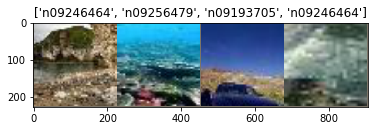

In [3]:
def tensorImgShow(img,title=''):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

tensorImgShow(out, title=[classNames[x] for x in classes])

In [4]:
def trainModel(model, criteria, optimizer, scheduler, num_epochs = 50):
    startTime = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if useGpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSize[phase]
            epoch_acc = running_corrects / datasetSize[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - startTime
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if useGpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(classNames[preds[j]]))
            tensorImgShow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [6]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 outputs

if useGpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = trainModel(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.4797 Acc: 0.4080
val Loss: 1.8454 Acc: 0.3440

Epoch 1/49
----------
train Loss: 1.2246 Acc: 0.5236
val Loss: 3.2773 Acc: 0.1560

Epoch 2/49
----------
train Loss: 1.1144 Acc: 0.5588
val Loss: 3.1997 Acc: 0.2200

Epoch 3/49
----------
train Loss: 1.0381 Acc: 0.6076
val Loss: 2.6435 Acc: 0.2760

Epoch 4/49
----------
train Loss: 1.0202 Acc: 0.6004
val Loss: 3.5417 Acc: 0.2000

Epoch 5/49
----------
train Loss: 0.9257 Acc: 0.6344
val Loss: 3.3611 Acc: 0.2600

Epoch 6/49
----------
train Loss: 0.9383 Acc: 0.6368
val Loss: 3.6068 Acc: 0.2480

Epoch 7/49
----------
train Loss: 0.8234 Acc: 0.6828
val Loss: 4.4287 Acc: 0.1960

Epoch 8/49
----------
train Loss: 0.7846 Acc: 0.7000
val Loss: 4.6487 Acc: 0.2000

Epoch 9/49
----------
train Loss: 0.7472 Acc: 0.7200
val Loss: 4.5652 Acc: 0.2000

Epoch 10/49
----------
train Loss: 0.7068 Acc: 0.7336
val Loss: 4.3701 Acc: 0.2080

Epoch 11/49
----------
train Loss: 0.7051 Acc: 0.7324
val Loss: 4.4229 Acc: 0.2000

Ep

In [8]:
torch.save(model_ft.state_dict(),'model_ft.pt')

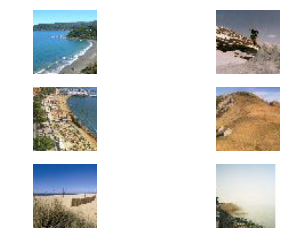

In [13]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,5)

if useGpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr = 0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

In [14]:
model_conv = trainModel(model_conv,criterion,optimizer_conv,exp_lr_scheduler,  num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5486 Acc: 0.3784
val Loss: 1.8441 Acc: 0.3000

Epoch 1/49
----------
train Loss: 1.3863 Acc: 0.4624
val Loss: 3.1643 Acc: 0.1560

Epoch 2/49
----------
train Loss: 1.3412 Acc: 0.4856
val Loss: 3.4538 Acc: 0.1560

Epoch 3/49
----------
train Loss: 1.3394 Acc: 0.4992
val Loss: 3.6464 Acc: 0.1840

Epoch 4/49
----------
train Loss: 1.3286 Acc: 0.4928
val Loss: 3.9423 Acc: 0.1760

Epoch 5/49
----------
train Loss: 1.2959 Acc: 0.5192
val Loss: 3.1014 Acc: 0.2560

Epoch 6/49
----------
train Loss: 1.2622 Acc: 0.5280
val Loss: 4.0177 Acc: 0.1880

Epoch 7/49
----------
train Loss: 1.1003 Acc: 0.5748
val Loss: 3.1731 Acc: 0.2400

Epoch 8/49
----------
train Loss: 1.0919 Acc: 0.5664
val Loss: 3.2488 Acc: 0.2560

Epoch 9/49
----------
train Loss: 1.1031 Acc: 0.5552
val Loss: 3.4171 Acc: 0.2600

Epoch 10/49
----------
train Loss: 1.1061 Acc: 0.5624
val Loss: 3.4119 Acc: 0.2200

Epoch 11/49
----------
train Loss: 1.1220 Acc: 0.5632
val Loss: 3.5011 Acc: 0.2400

Ep

In [15]:
torch.save(model_conv.state_dict(),'model_conv.pt')